<a href="https://colab.research.google.com/github/Jersonrn/Stable-Diffusion-XL/blob/master/Base%26Refiner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stable-Diffusion-XL** 🖼️

Notebook creado por **Jerson Rodriguez** ([@Jersonrn](https://github.com/Jersonrn))

In [ ]:
!pip install diffusers --upgrade
!pip install invisible_watermark transformers accelerate safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 102.1 MB/s eta 0:00:00


In [ ]:
from diffusers import DiffusionPipeline
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
# load stable-diffusion-xl-base-1.0
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
base.to("cuda")


Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.21.4",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "force_zeros_for_empty_prompt": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
#load stabilityai/stable-diffusion-xl-refiner-1.0
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to("cuda")

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

StableDiffusionXLImg2ImgPipeline {
  "_class_name": "StableDiffusionXLImg2ImgPipeline",
  "_diffusers_version": "0.21.4",
  "_name_or_path": "stabilityai/stable-diffusion-xl-refiner-1.0",
  "force_zeros_for_empty_prompt": false,
  "requires_aesthetics_score": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    null,
    null
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
def run_base(n_steps = 40, high_noise_frac = 0.8, prompt = ""):
  torch.cuda.empty_cache()

  # run base expert
  image = base(
      prompt=prompt,
      num_inference_steps=n_steps,
      denoising_end=high_noise_frac,
      output_type="latent",
  ).images

  return image

In [ ]:
def run_refiner(img, free_cache = True):
  # run refiner expert
  image = refiner(
      prompt=prompt,
      num_inference_steps=n_steps,
      denoising_start=high_noise_frac,
      image=img,
  )

  if free_cache:
    torch.cuda.empty_cache()

  return image

In [ ]:
def show_image(img):
  if isinstance(img, torch.Tensor):
    image_np = img[0].cpu().numpy().transpose(1, 2, 0)

    image_np = image_np.clip(0, 1)

    image_np = image_np.astype('float32')

  else:
    image_np = img.images[0]

    # Normalize
    image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

  # Show Image
  plt.imshow(image_np)
  plt.axis('off')
  plt.show()

In [ ]:
def save_download_image(img):
  #Save & Download Image
  img.images[0].save(f"{prompt[:50]}.png")
  files.download(f"{prompt[:50]}.png")

---

# ***AHORA SI VIENE LO CHIDO XD***

---

In [ ]:
# Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 40
high_noise_frac = 0.8

In [ ]:
prompt = input("Enter the prompt and hit Enter: ")

Enter the prompt and hit Enter: a cute kitten, Hyperdetailed Eyes, Tee-Shirt Design, Line Art, Black Background, Ultra Detailed Artistic, Detailed Gorgeous Face, Natural Skin, Water Splash, Colour Splash Art, Fire and Ice, Splatter, Black Ink, Liquid Melting, Dreamy, Glowing, Glamour, Glimmer, Shadows, Oil On Canvas, Brush Strokes, Smooth, Ultra High Definition, 8k, Unreal Engine 5, Ultra Sharp Focus, Intricate Artwork Masterpiece, Ominous, Golden Ratio, Highly Detailed, Vibrant, Production Cinematic Character Render, Ultra High Quality Model


In [ ]:
#prompt = 'waist-up, muted photo portrait titled "female Astronaut in a Jungle", broken helmet tangerine, muted palette, muted colors, detailed, 8k, reflections,'
#prompt = "Generate a coloring page that is perfect for a 5-year-old. I want it to be something fun and light-hearted, with characters and elements that capture a child's imagination. Please make sure it is suitable for coloring with bright colors and easy to use."
prompt = "a cute kitten, Hyperdetailed Eyes, Tee-Shirt Design, Line Art, Black Background, Ultra Detailed Artistic, Detailed Gorgeous Face, Natural Skin, Water Splash, Colour Splash Art, Fire and Ice, Splatter, Black Ink, Liquid Melting, Dreamy, Glowing, Glamour, Glimmer, Shadows, Oil On Canvas, Brush Strokes, Smooth, Ultra High Definition, 8k, Unreal Engine 5, Ultra Sharp Focus, Intricate Artwork Masterpiece, Ominous, Golden Ratio, Highly Detailed, Vibrant, Production Cinematic Character Render, Ultra High Quality Model"

Token indices sequence length is longer than the specified maximum sequence length for this model (110 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['k, unreal engine 5, ultra sharp focus, intricate artwork masterpiece, ominous, golden ratio, highly detailed, vibrant, production cinematic character render, ultra high quality model']
Token indices sequence length is longer than the specified maximum sequence length for this model (110 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['k, unreal engine 5, ultra sharp focus, intricate artwork masterpiece, ominous, golden ratio, highly detailed, vibrant, production cinematic character render, ultra high quality model']


  0%|          | 0/32 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (110 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['k, unreal engine 5, ultra sharp focus, intricate artwork masterpiece, ominous, golden ratio, highly detailed, vibrant, production cinematic character render, ultra high quality model']


  0%|          | 0/8 [00:00<?, ?it/s]

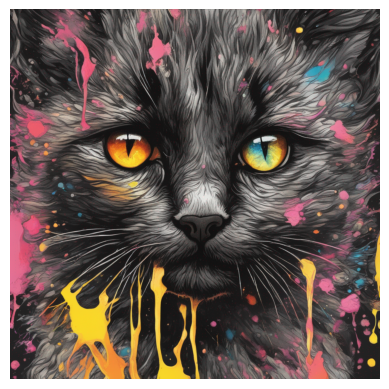

In [ ]:
image = run_base(n_steps, high_noise_frac, prompt)
#show_image(image)
image = run_refiner(image, free_cache = True)
show_image(image)

In [ ]:
save_download_image(image)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Tools**

In [ ]:
size_in_bytes = image.element_size() * image.nelement()
size_in_kb = size_in_bytes / 1024
print(size_in_kb)

In [ ]:
!nvidia-smi

In [ ]:
#base.to("cpu")